# Lab - Machine Learning Model Deployment

Deploying a machine learning, known as model deployment, simply means integrating a machine learning model into an existing production environment where it can take in an input and return an output. The purpose of the model deployment is to make the predictions from a trained machine learning model available to others. After training a model and evaluating it on the test set, it can be served in a format where it can be used by others when needed.

In this lab, you will be guided to turn your trained machine learning models into a web application where other users can interact with.

## Background

Machine learning models can be deployed in the server or on-device. In server-based deployment, there are three general ways to deploy the machine learning model: 1) one-off, 2) batch, and 3) real-time. One-off deployment does not need to continuously train a machine learning model. Instead, it can be trained once and pushed to production until its performance deteriorates enough to need some adjustments. Batch training allows up-to-date version of the model. Real-time training is possible with "online machine learning", where sequentially available data are used to update the best predictor for future data. 

In order for others to make use of the trained machine learning model, it should be accessed online through the Web, via a web framework. A web framework is a library of code that enables easier and rapid web application development and maintains the applications over time. The content that we interact on the Web is organised in webpages. A webpage is a document that can be displayed in a web browser. To access these webpages, a website should be visited by typing its corresponding URL or address. Therefore, a browser such as Google Chrome, Mozilla Firefox, and Microsoft Edge are used to interact with a website as a client. 

For a client to retrieve information from the Web, there has to be a web server. A web server is a computer software that processes clients' requests and sends back a response through the Internet. The client and the server communicate with each other using the Hypertext Protocol (HTTP Protocol). In many of today's applications, a dynamic server is more common which contains a static web server and maintains an application server that can interact with other servers as shown in the figure below. 

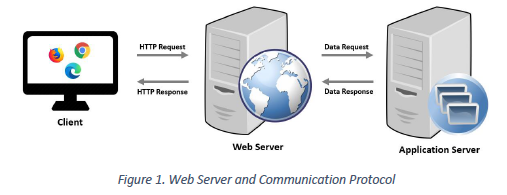

The application server updates the files before sending the response to the client. Therefore, whenever a client makes a HTTP request to the web server through the browser, the web server handles the request and runs the web application through an application server. The web server will then send the client the response. 

There are various web servers available, including Apache HTTP server, Microsoft Internet Information Server (IIS), and Nginx. There are also web frameworks, such as Flask and Django, that provide simpler ways to leverage Python to build applications that can run on the application server. In this lab guide, Flask will be used. 

The flow of deploying a machine learning model is presented in the figure below: 

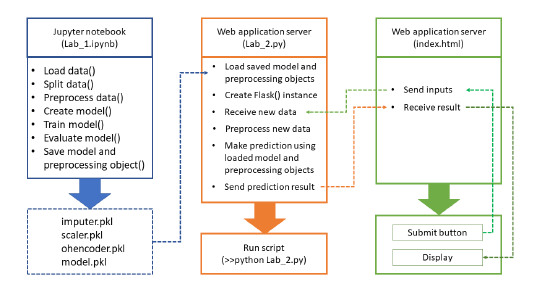

After creating a model using Jupyter Notebook, save the trained model and preprocessed objects. In the web application server, the web application script, html template, and saved models are stored in the same directory. Next, run the web application script to load the saved models and render the html template. When the web application script is running, it will wait for the html template to send new data (input by the user) and return the result back to be displayed on the html template. The interaction of the html template and the web application script is handled by the Flask framework, which is created in the web application script.

## Creating the model

In this section, we will save our trained model into a pickle file (.pkl) that will be used in our web application. 

In this lab guide, we will try to deploy the trained model we did on our 4th assignment (text processing): a classification model that determines if a text message is a spam message or not. You can refer back to the previous lab guide for detailed explanations of the code. The basic code for training the classification model will be shown here. We will use Random Forest classifier as our model of choice. At the end, once the model is trained, we will use "pickle" to save the trained model and the preprocessing objects. 

We will be using TfidfVectorizer to create the features. 

In [4]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import nltk
import pickle

%matplotlib inline
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
data = pd.read_csv('SMSSpamCollection.tsv', sep='\t', names=['label', 'body_text'], header=None)
data.head()

,label,body_text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [7]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def clean_text(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(' ')), 3) * 100

# calculate the length of messages excluding spaces
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(' '))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))
data.head()

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_fit = tfidf_vect.fit(data['body_text'])
X_tfidf = tfidf_fit.transform(data['body_text'])
X_tfidf_feat = pd.concat([data['body_len'], data['punct%'], pd.DataFrame(X_tfidf.toarray())], axis=1)

X_tfidf_feat.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,8097,8098,8099,8100,8101,8102,8103,8104,8105,8106
0,160,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_feat, data['label'], test_size=0.2)

In [6]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Prediction accuracy: ', accuracy_score(y_test, y_pred))

Prediction accuracy:  0.9712746858168761


As we can see, this yields a prediction accuracy of above 97%. We will save two things: 

1. The trained random forest model
2. The trained TF-IDF model

These models will be called back later for implementation. 

In [8]:
pickle.dump(tfidf_fit, open('tfidf.pkl', 'wb'))
pickle.dump(rf, open('rf_trained.pkl', 'wb'))

Now, refer to oneoff_app.py for further implementation. 